variational autoencoders are types for networks that can be used to generate datapoints that don't exist in the dataset  

![VAE](https://miro.medium.com/max/3374/1*22cSCfmktNIwH5m__u2ffA.png)

it's a neural network that learns to encode an image into a mean and std (or the log of that)  and during the training we sample from those mean and std to regenerate the same image 
but in the generation part for data not in the dataset we could just sample from a random multivariate normal 

this playlist can give some intuition about them but the topic needs more  research

https://www.youtube.com/playlist?list=PLdxQ7SoCLQANizknbIiHzL_hYjEaI-wUe

Here I used  pytorch to build a model(a weak one) that could generate faces with specific features like hair color , gender , beard , specific skin 

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("gpu up")
else:  
    dev = "cpu"  
device = torch.device(dev)

gpu up


In [4]:
df = pd.read_csv("../../input/list_attr_celeba.csv")

In [3]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3
    
df["Hair_Color"] = df.apply(haircolor,axis=1)

In [4]:
"""
for simplicity I decided to make the VAE capture just for attributes 

Hair Color (blond,brown,black and neither of these(or unknown))
Pale Skin 
Gender 
Beard (in case of male)
"""

df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]

In [5]:
"""
replacing -1 with 0 without affecting the the 1 values 

"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0)) 
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))


In [6]:
df

,image_id,Hair_Color,Pale_Skin,Male,No_Beard
0,000001.jpg,1,0,0,1
1,000002.jpg,1,0,0,1
2,000003.jpg,3,0,1,1
3,000004.jpg,3,0,0,1
4,000005.jpg,3,0,0,1
...,...,...,...,...,...
202594,202595.jpg,0,0,0,1
202595,202596.jpg,0,1,1,1
202596,202597.jpg,2,0,1,1
202597,202598.jpg,2,0,0,1


In [7]:
faces =[]
for i in df.iloc[:20000].image_id:
    pic = Image.open("../input/celeba-dataset/img_align_celeba/img_align_celeba/"+i)
    pic = pic.resize((64,64))
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    pix = pix/255
    """
    for the images I had to use np.moveaxis to change the shape from  (64,64,3) to (3,64,64)
    without messing up the image 
    
    """
    faces.append(np.moveaxis(pix,-1,0).tolist())
    
faces = np.array(faces)

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(3,64,3,1,1)
        self.conv2 = nn.Conv2d(64,64,3,1,1)
        self.conv3 = nn.Conv2d(64,64,4,2,1)
        self.conv4 = nn.Conv2d(64,128,4,2,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)


        
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        """
        convtranspose  is different from the regular conv layer (looking at the equations of two of them )
        this link shows examples about it 
        https://towardsdatascience.com/is-the-transposed-convolution-layer-and-convolution-layer-the-same-thing-8655b751c3a1
        
        """
        self.transconv1 = nn.ConvTranspose2d(64+ 40,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,3,4,2,1)
        
        """
        I think Embeddings layers were pretty good  so every state was converted into a vector like 
        Beard or no beard -> vector of 10 weights
        Male or Female -> vector  of 10 weights 
        
        """
        self.hairEmbedding = nn.Embedding(4,10)
        self.beardEmbedding = nn.Embedding(2,10)
        self.genderEmbedding = nn.Embedding(2,10)
        self.paleSkinEmbedding = nn.Embedding(2,10)

        
    def forward(self,x):
        z = x[:,:64]
        hair = self.hairEmbedding(x[:,64].long())
        paleSkin = self.paleSkinEmbedding(x[:,65].long())
        gender = self.genderEmbedding(x[:,66].long())
        beard = self.beardEmbedding(x[:,67].long())
        """
        Concating the embeddings and the encoded image
        """
        z = torch.cat([z,hair,beard,gender,paleSkin],dim=1)
        
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out= self.transconv2(out)
        out = F.relu(out)

        out= self.transconv3(out)
        out = F.relu(out)

        out= self.transconv4(out)
        out = F.relu(out)

        return out
        
class CVAE(nn.Module):
    def __init__(self,encoder,decoder):
        super(CVAE,self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
    def forward(self,x,attrs):
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        # this part is for the reparameterization trick
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        
vae = CVAE(Encoder,Decoder)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(104, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [9]:
def ceil(a,b):
    return -(-a//b)

In [ ]:

"""

loss function contains two parts 
reconstruction  loss and kullback leibler divergence (it basically measures how two distributions are different)

"""
def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss +  KLD

epochs = 1201

batch_size= 256
optimizer = optim.Adagrad(vae.parameters(),lr = 0.001)

npData = df.iloc[:20000].to_numpy()


n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
losstrack = []
for e in range(epochs):
    losses = []
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
#         break
        imgs = faces[i * better_batch_size: (i+1) * better_batch_size]
        imgs = torch.Tensor(imgs.astype('float16')).to(device)
        vae.zero_grad()
        recon_imgs,mu,logvar = vae(imgs,attrs)
        err = loss_function(recon_imgs,imgs,mu,logvar)
        err.backward()
        optimizer.step()
        losses.append(err.item())
    losstrack.append(np.mean(losses))
    if e % 100 == 0: 
        torch.save(vae.state_dict(), "./vae.pt")
        print(np.mean(losses), "mean loss", e)

        
    







In [10]:
"""I just loaded the model I saved while training"""

checkpoint = torch.load("../input/my-cvae-model/vae.pt")
vae.load_state_dict(checkpoint)

<All keys matched successfully>

In [11]:
def showImage(x):
    attrs = torch.Tensor(x)
    h = torch.cat((torch.randn(1,64),attrs),dim=1).to(device)
    img = vae.decoder(h)
    img = img.cpu().detach().numpy().reshape(3,64,64)
    img = np.moveaxis(img,0,-1)
    return img

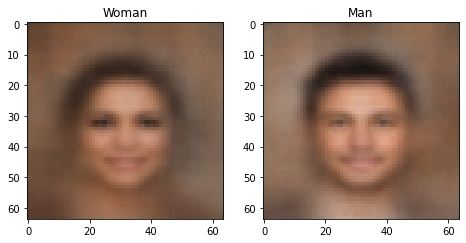

In [12]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("Woman")
axarr[1].imshow(showImage([[2,0,1,0]]))
axarr[1].set_title("Man")

f.subplots_adjust(hspace=0.3,left=2,right=3)

Here showing what could the model do after the training 

it could kinda generate different genders

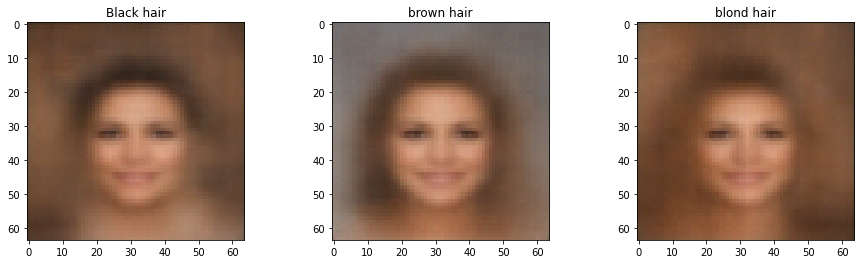

In [13]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("Black hair")
axarr[1].imshow(showImage([[1,0,0,1]]))
axarr[1].set_title("brown hair")
axarr[2].imshow(showImage([[0,0,0,1]]))
axarr[2].set_title("blond hair")


f.subplots_adjust(hspace=0.3,left=2,right=4)

it also can make different hair colors but it mostly was trying to just fill the image outside with the color

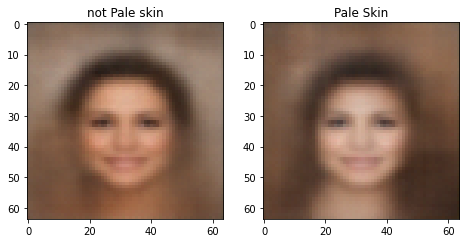

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("not Pale skin")
axarr[1].imshow(showImage([[2,1,0,1]]))
axarr[1].set_title("Pale Skin")

f.subplots_adjust(hspace=0.3,left=2,right=3)

it could get doing the skin part correctly 

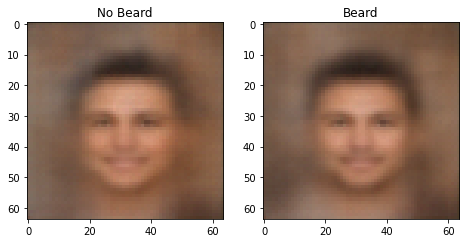

In [15]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,1,1]]))
axarr[0].set_title("No Beard")
axarr[1].imshow(showImage([[2,0,1,0]]))
axarr[1].set_title("Beard")

f.subplots_adjust(hspace=0.3,left=2,right=3)

well this one is not good maybe the model needs to be bigger(and also more data)  because there is barely a difference between the two images 

upvote if you find this kernel useful